# Analysis of the Medicare Provider Charge Inpatient Dataset from 2014


## Motivation for this analysis:
The American Healthcare system is in disarray. Despite providing some of the most technologically sophisticated care in the world, our country is paying exorbitant amounts for mediocre health outcomes. Hiding within these aggregate summary statements are the individuals suffering from this system’s consequences - the patients and families who are bankrupted by excessive hospital bills or financially hamstrung by the costs of managing a chronic disease. 

Answering why healthcare costs so much is a difficult task. On an individual level, the demand for healthcare is fairly inelastic; there is no price too great a family or person might pay to avoid catastrophic or fatal illness. Most Americans now have health insurance, which shields consumers from the true cost of health services by paying large portions of most medical expenses. In America, there are public insurers (such as Medicare and Medicaid) and private insurers. While Medicare pays providers a flat fee, private insurance companies negotiate with individual hospital providers to determine what percent of the hospital charge they will pay. The relative bargaining power between the these insurers and providers plays a large role in determining the final cost. 

In 2013, The Center for Medicare and Medicaid Services began releasing annual datasets on the average charges health providers requested in treating medicare payments. These data revealed the ‘rate card’ (i.e. the full charge before insurance company discounts) each hospital charges for common procedures and services reimbursed by medicare. The data was shocking in its variability and seeming arbitrariness; there seemed to be no rational explanation for the range of charges hospitals made for the same procedures. 

I was drawn to this dataset as I believe it has the potential to offer insight into why healthcare is such a frustrating issue in the United States. As a future physician, I feel a better understanding of how the healthcare system works will enable me to take better care of my patients and advocate for policy changes that improve public health.

## A description of the Datasets

Three datasets were used for the analysis. The main medicare charge dataset was obtained from the [Centers from Medicare and Medicaid Services (CMS)](https://www.cms.gov/Research-Statistics-Data-and-Systems/Statistics-Trends-and-Reports/Medicare-Provider-Charge-Data/Inpatient2011.html). According to the descrption on the CMS site, this dataset "consistes of hospital-specific charges for the more than 3,000 U.S. hospitals that receive Medicare Inpatient Prospective Payment System (IPPS) payments for discharges, paid under Medicare based on a rate per discharge using the Medicare Severity Diagnosis Related Group (MS-DRG) for Fiscal Year (FY) 2014." I was most interested in the "Average Covered Charges" column, i.e. the amount individual providers requested Medicare reimburse them for each hospitalization of a given diagnosis (DRG). Included in the dataset was also geographic information, such as the state and Hospital Referral Region (HRR) where each provider was located. An HRR, according to the Dartmouth Atlas of Healthcare, "represents regional health care markets for tertiary medical care that generally require the services of a major referral center", i.e. the region within which all smaller hospitals with a more narrow range of clinical services refer their patients to larger hopsitals that can treat more complicated patients. 

The second dataset consistend of Medicare Fee-for-Service Enrollment by State and Hospital Referral Region. As will be seen below, knowing medicare enrollment rates by state allow us to assess whether the average covered charge each hospital levied against medicare was related to the number of medicare enrollee's in their area. 

The third dataset, obtained from the [Open Payments Site](https://www.cms.gov/OpenPayments/About/Resources.html), contains a list of teaching hopsitals, i.e. healthcare institutions where medical students and residents are trained. This dataset, in tandem with the Medicare Charge data, allows us to assess whether healthcare is more expensive at teaching hopsitals (as is commonly believed) than at non-teaching hopsitals. 

Representative samples for each dataset are displayed immediately below.

In [1]:
%matplotlib inline 
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import math
import os
import scipy.stats as stats 

# medicare charge data from CMS
medicare_charge_data = pd.read_csv("Medicare_Provider_Charge_Inpatient_DRGALL_FY2014.csv")
df = medicare_charge_data

# Medicare Fee For Service Enrollment by State
HRR_names_and_beneficiaries = pd.read_excel("Medicare_Fee-For-Service_Enrollment_by_State_and_HRR_CY2014.xlsx", sheetname=3, skiprows=5)

# list of teaching hospitals
teaching_hospitals = pd.read_excel("2015-Reporting-Year-Teaching-Hospital-[October-2014].xlsx", skiprows=4)

# convenience variables
state_list = df['Provider State'].unique() # total of 51 (includes DC)
DRG_list = df['DRG Definition'].unique() # total of 564
provider_list = df['Provider Id'].unique() # total of 3276
hrr = 'Hospital Referral Region (HRR) Description'
acc = 'Average Covered Charges'
drg_def = "DRG Definition"

#### Representative Sample from the primary dataset of Medicare Charges from 2014 from the CMS website

In [2]:
df[:3]

,DRG Definition,Provider Id,Provider Name,Provider Street Address,Provider City,Provider State,Provider Zip Code,Hospital Referral Region (HRR) Description,Total Discharges,Average Covered Charges,Average Total Payments,Average Medicare Payments
0,001 - HEART TRANSPLANT OR IMPLANT OF HEART ASS...,10033,UNIVERSITY OF ALABAMA HOSPITAL,619 SOUTH 19TH STREET,BIRMINGHAM,AL,35233,AL - Birmingham,13,1172866.385,251876.3077,244457.9231
1,001 - HEART TRANSPLANT OR IMPLANT OF HEART ASS...,30103,MAYO CLINIC HOSPITAL,5777 EAST MAYO BOULEVARD,PHOENIX,AZ,85054,AZ - Phoenix,20,437531.300,240422.8000,133509.5500
2,001 - HEART TRANSPLANT OR IMPLANT OF HEART ASS...,50108,SUTTER GENERAL HOSPITAL,2801 L STREET,SACRAMENTO,CA,95816,CA - Sacramento,25,815674.120,233197.4800,221681.8000


#### Representative Sample of The Medicare Fee For Service Enrollment by State and HRR from the CMS site

In [3]:
HRR_names_and_beneficiaries.head()

,HRR Code,HRR Name,Medicare Beneficiaries Enrolled in FFS Part A,Medicare Beneficiaries Enrolled in FFS Part B
0,NaN,United States,36684241,33645448
1,1.0,AL - Birmingham,332912,313260
2,2.0,AL - Dothan,68120,65367
3,5.0,AL - Huntsville,100313,93922
4,6.0,AL - Mobile,108930,102153


#### Representative Sample of the 2015 Reporting Year (i.e. 2014) For Teaching Hospitals from the Open Payment Website

In [4]:
teaching_hospitals[:3]

,TIN,Hospital Name,PECOS Legal Business Name,Street Address,PO Box,City,State,Zip Code,Street Address 1,Street Address 2,City.1,State.1,Zip Code
0,920016429,PROVIDENCE ALASKA MEDICAL CENTER,Providence Health & Services - Washington,3200 PROVIDENCE DRIVE,PO BOX 196604,ANCHORAGE,AK,99519,3200 Providence Dr,NaN,Anchorage,AK,99508
1,461468253,CALLAHAN EYE FOUNDATION HOSP,Callahan Eye Hospital Health Care Authority,1720 UNIVERSITY BOULEVARD,NaN,BIRMINGHAM,AL,35233,1720 University Blvd,Suite 500,Birmingham,AL,35233
2,636001579,COOPER GREEN MERCY HOSPITAL,Jefferson County Commission,1515 SIXTH AVENUE SOUTH,NaN,BIRMINGHAM,AL,35233,1515 6th Ave S,NaN,Birmingham,AL,35233


## A description of the data on the National Level

Conatined within these files are hundreds of diagnoses being charged by thousands of hospitals distributed accross 50 states (+ Washington D.C) at different types of institutions (teaching vs. non-teaching) with different medicare populations within different regional private insurance markets. With so many potential avenues of exploration, it can be challenging to focus one's analysis sufficently to derive interesting conclusions. We will attempt to do so by starting broadly at the national level and then narrowing our analysis to the most popular DRG's (by number of total discharges billed with that diagnosis nationally). 

#### Here, a function is defined that takes a DRG and location and returns useful summary statistics about  that DRG at either the national or state level.

In [5]:
df_description_by_DRG = df.groupby('DRG Definition').describe().drop(['Provider Id', 'Provider Zip Code'], 1)
df_description_by_DRG_by_state = df.groupby(['DRG Definition', 'Provider State']).describe().drop(['Provider Id', 'Provider Zip Code'], 1)

In [6]:
def DRG_state_lookup(DRG, location):
    """Paremeters: DRG = to a DRG w/in the above df's, and Location = either a state or 'US'
    Returns the df.describe() row for the above groupby df's."""
    try: 
        if location == 'US':
            return df_description_by_DRG[df_description_by_DRG.index.get_level_values(0).str.contains(DRG)]
        else: 
            state = location
            return df_description_by_DRG_by_state[
                (df_description_by_DRG_by_state.index.get_level_values(0).str.contains(DRG)) & 
                (df_description_by_DRG_by_state.index.get_level_values(1) == state)]
    except KeyError as e:
       print("error: check your inputs. ") 

#### As an example, here is a summary of DRG - 004 both nationally States and in Califorinia. 

In [7]:
# National Data
DRG_state_lookup('004', location='US')

Average Covered Charges  \
DRG Definition                                                                      
004 - TRACH W MV 96+ HRS OR PDX EXC FACE, MOUTH... count             5.750000e+02   
                                                   mean              3.199283e+05   
                                                   std               1.850113e+05   
                                                   min               6.036871e+04   
                                                   25%               2.006250e+05   
                                                   50%               2.719623e+05   
                                                   75%               3.940423e+05   
                                                   max               1.420373e+06   

                                                          Average Medicare Payments  \
DRG Definition                                                                        
004 - TRACH W MV 96+ HRS OR PDX EXC FACE, MOUTH... count                 575.000000   
                                                   mean                72172.939143   
                                                   std                 25625.880543   
                                                   min                 37237.315790   
                                                   25%                 55374.520190   
                                                   50%                 65189.818180   
                                                   75%                 81871.754465   
                                                   max                287217.288900   

                                                          Average Total Payments  \
DRG Definition                                                                     
004 - TRACH W MV 96+ HRS OR PDX EXC FACE, MOUTH... count              575.000000   
                                                   mean             79539.612315   
                                                   std              28759.775715   
                                                   min              41122.944440   
                                                   25%              59856.666665   
                                                   50%              71838.400000   
                                                   75%              91094.196970   
                                                   max             298575.955600   

                                                          Total Discharges  
DRG Definition                                                              
004 - TRACH W MV 96+ HRS OR PDX EXC FACE, MOUTH... count        575.000000  
                                                   mean          20.476522  
                                                   std           11.529196  
                                                   min           11.000000  
                                                   25%           13.000000  
                                                   50%           16.000000  
                                                   75%           24.000000  
                                                   max           96.000000

In [8]:
# California Data
DRG_state_lookup('004', 'CA')

Average Covered Charges  \
DRG Definition                                     Provider State                                  
004 - TRACH W MV 96+ HRS OR PDX EXC FACE, MOUTH... CA             count             6.000000e+01   
                                                                  mean              5.887694e+05   
                                                                  std               2.788728e+05   
                                                                  min               2.208537e+05   
                                                                  25%               3.927383e+05   
                                                                  50%               5.047612e+05   
                                                                  75%               7.370750e+05   
                                                                  max               1.420373e+06   

                                                                         Average Medicare Payments  \
DRG Definition                                     Provider State                                    
004 - TRACH W MV 96+ HRS OR PDX EXC FACE, MOUTH... CA             count                  60.000000   
                                                                  mean                99957.191559   
                                                                  std                 31263.531568   
                                                                  min                 59034.333330   
                                                                  25%                 80485.887360   
                                                                  50%                 90953.787880   
                                                                  75%                106935.309750   
                                                                  max                208698.842100   

                                                                         Average Total Payments  \
DRG Definition                                     Provider State                                 
004 - TRACH W MV 96+ HRS OR PDX EXC FACE, MOUTH... CA             count               60.000000   
                                                                  mean            104880.581074   
                                                                  std              35891.605550   
                                                                  min              60552.600000   
                                                                  25%              82647.900625   
                                                                  50%              93663.380340   
                                                                  75%             113179.053550   
                                                                  max             228170.684200   

                                                                         Total Discharges  
DRG Definition                                     Provider State                          
004 - TRACH W MV 96+ HRS OR PDX EXC FACE, MOUTH... CA             count         60.000000  
                                                                  mean          14.900000  
                                                                  std            4.057636  
                                                                  min           11.000000  
                                                                  25%           12.000000  
                                                                  50%           13.500000  
                                                                  75%           17.000000  
                                                                  max           28.000000

## Q1: How does the cost of healthcare vary by state? 


### Visualizing the average charge requested from Medicare for a hospitalization

A box plot of the average charge for a given hospital stay (as measured by total discharges across all DRG's) per state is useful in gauging how the cost of healthcare varies by state.

In [9]:
# calculating average cost for each hospitalization 
# (sum(avg cost per DRG * total discharges per DRG) / total discharges) per institution
# and creating a column of it in a copied dataframe to graph

df_total_charges = df
df_total_charges["Total_Charge"] = df_total_charges[acc] * df_total_charges['Total Discharges']
df_total_charges_g = df_total_charges.groupby(['Provider State', 'Provider Id']).agg(
    {"Total_Charge" : np.sum, "Total Discharges" : np.sum})
df_total_charges_g['Avg_Charge_per_Discharge'] = df_total_charges_g.Total_Charge / df_total_charges_g['Total Discharges']

#### Box plot of the Average Charge per Hospitalization per State

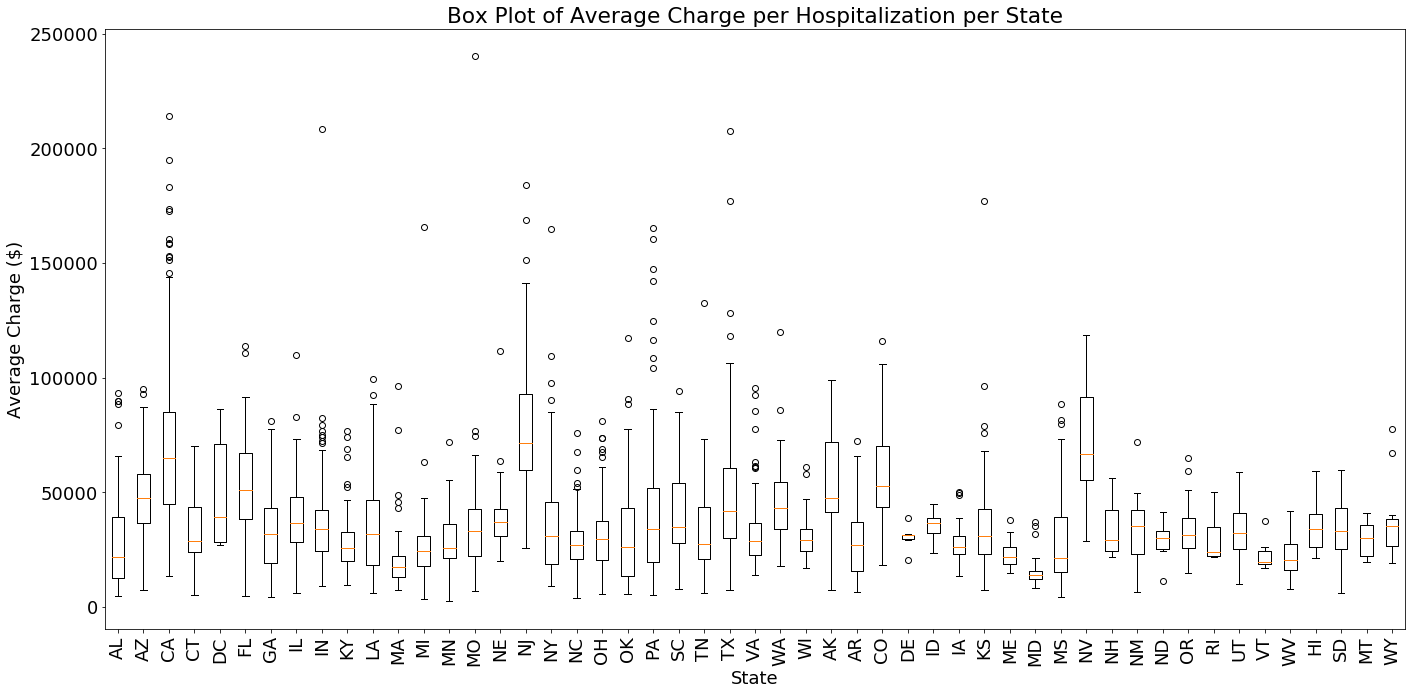

In [10]:
font = {'family' : 'DejaVu Sans',
        'weight' : 'normal',
        'size'   : 18}

# this seems to reset the font settings for all of matplotlib
# look into this more
plt.rc('font', **font)

data_to_plot = [df_total_charges_g.loc[state, :]['Avg_Charge_per_Discharge'] for state in state_list]
fig = plt.figure(1, figsize=(20,10))
ax = fig.add_subplot(111)
bp = ax.boxplot(data_to_plot, labels=state_list)
plt.title("Box Plot of Average Charge per Hospitalization per State")
plt.xticks(rotation='vertical')
plt.ylabel("Average Charge ($)")
plt.xlabel("State")
plt.tight_layout()
plt.show()

As the above graph demonstrates, there is substantial variation between states on the average total chage to medicare for each hospitalization. However, this is a rather superficial assesment of the cost given how different each region is in terms of the conditions they treat, populaton density, teaching vs. non-teaching institutions and number of medicare beneficiaries. Comparing the average charge requested from medicare for a particular DRG across states may be more enlightening.

#### Box plot of the average cost in each state for the nation's most popular DRGs (by total number of discharges) 

In [11]:
df_DRG_counts = df.groupby('DRG Definition').agg({'Total Discharges' : np.sum})
top_five_DRGs = df_DRG_counts.sort_values('Total Discharges', ascending=False)[:5].index

Top five DRGs:
470 - MAJOR JOINT REPLACEMENT OR REATTACHMENT OF LOWER EXTREMITY W/O MCC
871 - SEPTICEMIA OR SEVERE SEPSIS W/O MV 96+ HOURS W MCC
291 - HEART FAILURE & SHOCK W MCC
292 - HEART FAILURE & SHOCK W CC
392 - ESOPHAGITIS, GASTROENT & MISC DIGEST DISORDERS W/O MCC



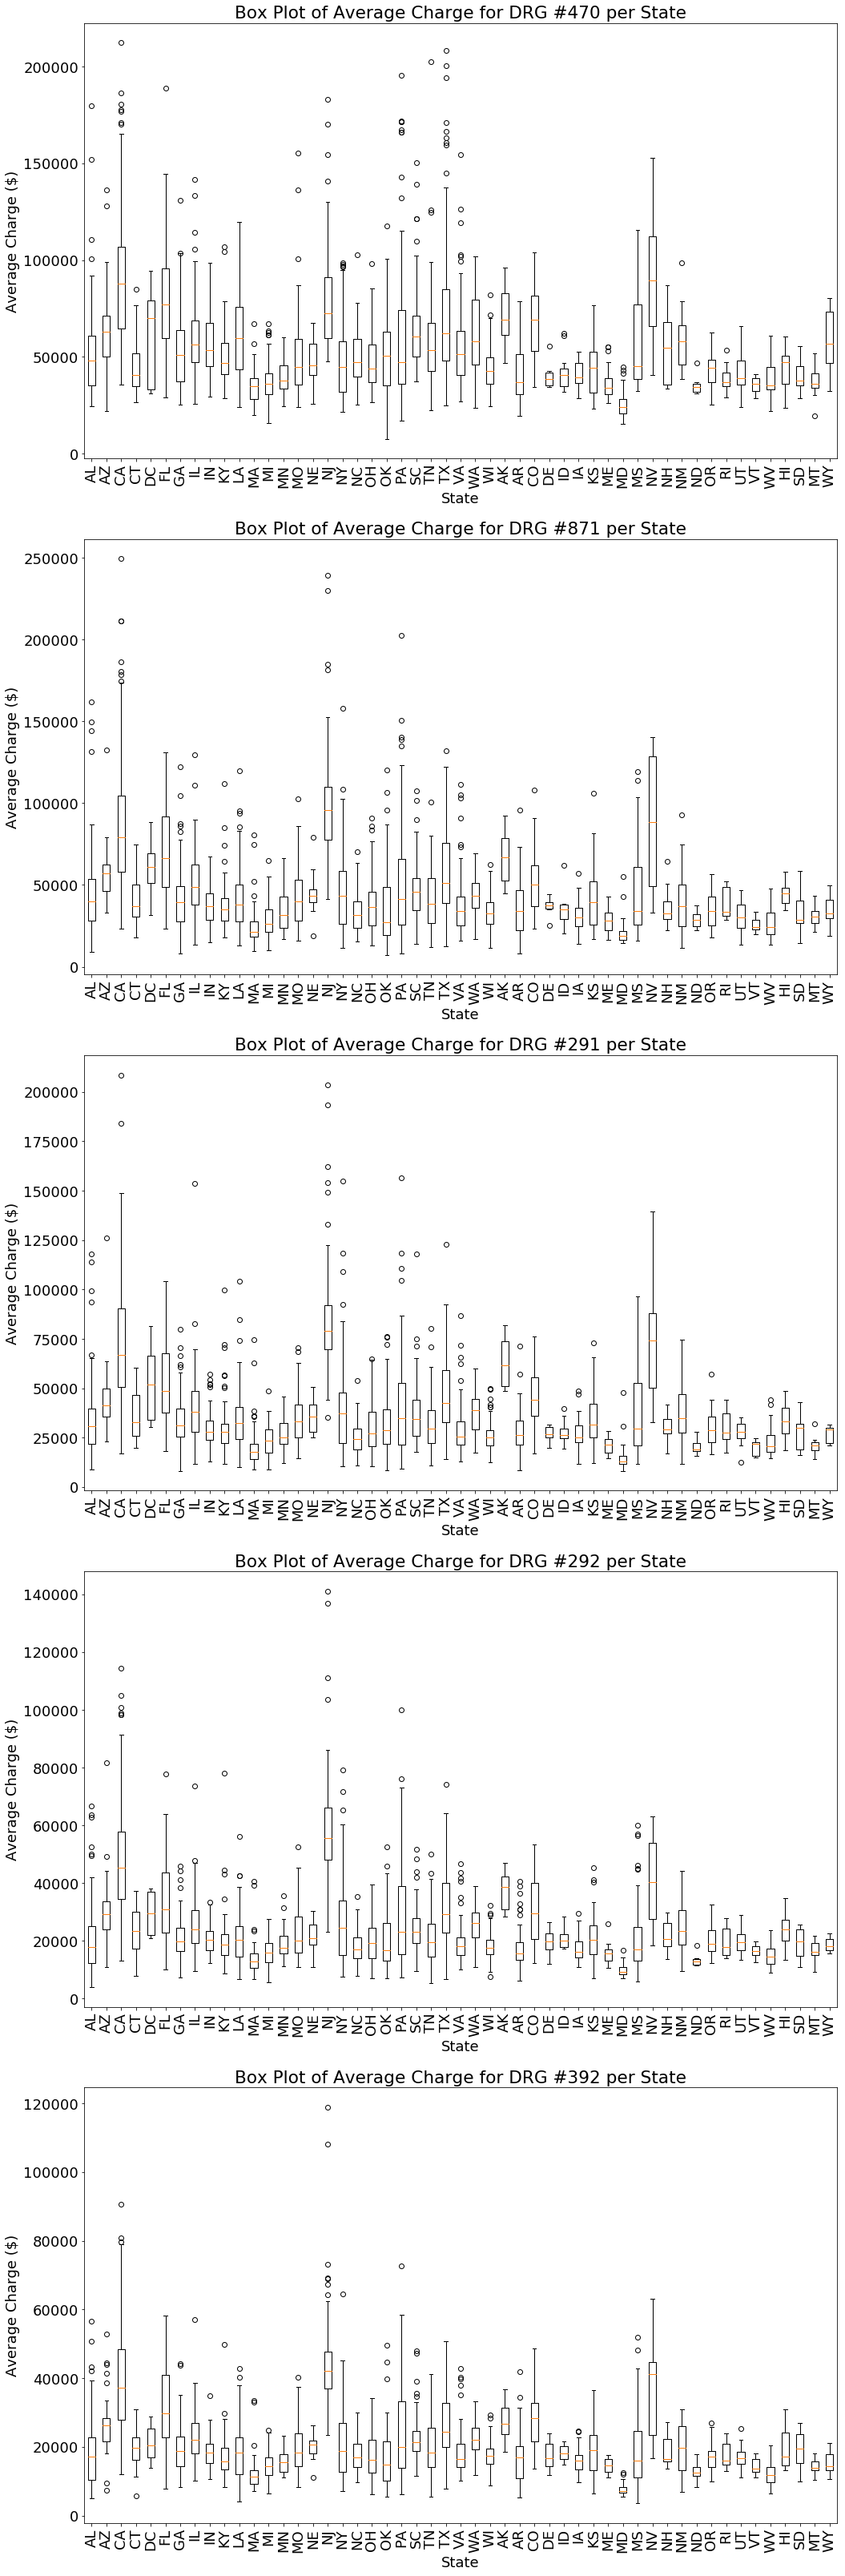

In [12]:
ind = 1
for DRG in top_five_DRGs:

    data_to_plot = [df[(df['DRG Definition'] == DRG) & (df['Provider State'] == state)][acc] for state in state_list]
    fig = plt.figure(1, figsize=(15,45))
    ax = fig.add_subplot(5, 1, ind)
    bp = ax.boxplot(data_to_plot, labels=state_list)
    plt.title("Box Plot of Average Charge for DRG #{} per State".format(DRG.split(' ')[0]))
    plt.xticks(rotation='vertical')
    plt.ylabel("Average Charge ($)")
    plt.xlabel("State")
    plt.tight_layout()

    ind += 1
print("Top five DRGs:")
for DRG in top_five_DRGs:
    print(DRG)
print()
plt.show()

The above boxplots show not only that there is substantial variation of medicare charges accross states for the above DRG's, but that state's relative costs when compared to each othe remains consistent (at least for the DRG's assessed). Further analysis would be necessary to see whether that generally holds for all DRG's.

In [13]:
# reset matplotlib fonts
plt.rcdefaults()

## Q2: Which hospital charges the least for each DRG? The most?

Given the variation in hospital charges, and the prospect that certain patients may be faced with  radically different hopsital bills depending on their insurance, it is valuable for healthcare consumers to know where the least and most expensive care can be purchased. Directly below is a function I defined that provides that information, either nationally or by state.

In [14]:
def min_max_cost_for_DRG(df, DRG, state):
    """Takes df, DRG (though this can just be an abbreviated DRG in string form, e.g. 014) 
    and two letter state abbreviation or 'US' as parameters. Will then print the Cheapest
    provider and most expensive provider in either the state and US of that specified 
    procedure. The df can be raw data if desired, or can be the min_max df
    
    Note, the dataset does not include all DRG numbers (e.g. 018). If it is not
    within the dataframe, then the function will display all available DRGs
    and notify you"""
    
    most_expensive = df.groupby(['Provider State', 'DRG Definition'])['Average Covered Charges'].transform(max)
    least_expensive = df.groupby(['Provider State', 'DRG Definition'])['Average Covered Charges'].transform(min)
    df_copy = df
    df_copy['most_expensive'] = most_expensive.values
    df_copy['least_expensive'] = least_expensive.values
    min_max_df = df_copy[(df_copy[acc] == df_copy['most_expensive']) | (df_copy[acc] == df_copy['least_expensive'])]
    
    try: 
        if state != 'US':
            prov_df = df_copy[(df_copy['Provider State'] == state) & (df_copy['DRG Definition'].str.contains(DRG))]
            min_prov = prov_df[prov_df[acc]==prov_df['least_expensive']]
            max_prov = prov_df[prov_df[acc]==prov_df['most_expensive']]
        else: 
            us_df = df_copy[df_copy['DRG Definition'].str.contains(DRG)]
            max_cost, min_cost = us_df[acc].max(), us_df[acc].min()
            min_prov = us_df[us_df[acc] == min_cost]
            max_prov = us_df[us_df[acc] == max_cost]
        dx = min_prov['DRG Definition'].values[0]
        min_prov_p, min_prov_a = min_prov['Provider Name'].values[0], min_prov[acc].values[0]
        max_prov_p, max_prov_a = max_prov['Provider Name'].values[0], max_prov[acc].values[0]


        x_prov_a = max_prov['Provider Name'].values[0], max_prov[acc].values[0]
        print("Procedure: ", dx)
        print("Cheapest Provider in {}: {} -- ${}".format(state, min_prov_p, min_prov_a))
        print("Most Expensive Provider in {}: {} -- ${}".format(state, max_prov_p, max_prov_a))
    except IndexError:
        print(DRG_list)
        print()
        print('This DRG is not present in the dataset. See above for the available DRG\'s and try again.')

#### Example fuciton call using DRG 014 - Allogenic Bone Marrow Transplant, both nationally and in the state of California 

In [15]:
# this is a function call of the function above
min_max_cost_for_DRG(df, '014', 'US')

Procedure:  014 - ALLOGENEIC BONE MARROW TRANSPLANT
Cheapest Provider in US: JOHNS HOPKINS HOSPITAL, THE -- $131667.6923
Most Expensive Provider in US: STANFORD HOSPITAL -- $702608.3333


In [16]:
min_max_cost_for_DRG(df, '014', 'CA')

Procedure:  014 - ALLOGENEIC BONE MARROW TRANSPLANT
Cheapest Provider in CA: RONALD REAGAN U C L A MEDICAL CENTER -- $396286.7273
Most Expensive Provider in CA: STANFORD HOSPITAL -- $702608.3333


## Q3 - Which hospitals are the most expensive for the most DRG's in the country? Least expensive?

Given the above function lets us see which hospitals charge the most and least for each diagnosis, it seemed like an interesting follow up to quantify how frequently these institutions with the highest and lowest fees were either the most or least expensive for a given DRG. 

In [17]:
country_DRG_max_and_min_charges = df
country_DRG_max_and_min_charges['most_expensive'] = df.groupby(['DRG Definition'])['Average Covered Charges'].transform(max)
country_DRG_max_and_min_charges['least_expensive'] = df.groupby(['DRG Definition'])['Average Covered Charges'].transform(min)
min_max_df = country_DRG_max_and_min_charges[(country_DRG_max_and_min_charges[acc] == country_DRG_max_and_min_charges['most_expensive']) | (country_DRG_max_and_min_charges[acc] == country_DRG_max_and_min_charges['least_expensive'])]

idx = min_max_df['most_expensive'] == min_max_df[acc]
max_providers = min_max_df[idx]
idx = min_max_df['least_expensive'] == min_max_df[acc]
min_providers = min_max_df[idx]

max_counts = max_providers.groupby('Provider Name')['Provider Id'].count().sort_values(ascending=False).to_frame()
min_counts = min_providers.groupby('Provider Name')['Provider Id'].count().sort_values(ascending=False).to_frame()

#### The 10 Institutions that charge the _most_ for the most diagnoses (max_counts representing the number of DRG's they charged the highest value for)

In [18]:
max_counts[:10]

,Provider Id
Provider Name,
CEDARS-SINAI MEDICAL CENTER,64
STANFORD HOSPITAL,63
FLORIDA HOSPITAL,29
CAREPOINT HEALTH - BAYONNE MEDICAL CENTER,21
CAREPOINT HEALTH-CHRIST HOSPITAL,20
NEW YORK-PRESBYTERIAN HOSPITAL,19
UNIVERSITY OF CALIFORNIA DAVIS MEDICAL CENTER,18
UPMC PRESBYTERIAN SHADYSIDE,17
UCSF MEDICAL CENTER,13


#### The 10 Institutions that charge the _least_ for the most diagnoses

In [19]:
min_counts[:10]

,Provider Id
Provider Name,
ANNE ARUNDEL MEDICAL CENTER,33
"JOHNS HOPKINS HOSPITAL, THE",25
UNIVERSITY OF MARYLAND ST JOSEPH MEDICAL CENTER,17
SUBURBAN HOSPITAL,17
MERITUS MEDICAL CENTER,16
"CHRISTIANA CARE HEALTH SERVICES, INC.",15
UNIVERITY OF MD BALTO WASHINGTON MEDICAL CENTER,15
UNIVERSITY OF MARYLAND MEDICAL CENTER,15
FLORIDA HOSPITAL,15


## Q4: Which is the most expensive tertiary referral center in the country? Which is the least?

According to Wikipedia, a "tertiary referral hospital (also called a tertiary hospital, tertiary referral center, or tertiary care center, or tertiary center) is a hospital that provides tertiary care, which is health care from specialists in a large hospital after referral from primary care and secondary care."

A quick-and-dirty way to select out tertiary care centers is to limit our analysis to hospitals that performed any organ transplants as transplant services are limited to tertiary care centers. Limiting our analysis to tertiary care centers helps ensure that we are comparing hospitals that charged for the same or similar DRG's. Without doing so, the average of the ACC will be skewed towards hospitals that offered more expensive services. 

To determine which hospital is the most and least expensive, we need a good marker of overall hospital cost. The average of the averaged covered charge (i.e. the sum of the average covered charge for each diagnosis divdied by the number of diagnoses) seems reasonable. 

In [20]:
transplant_hospitals = df[df[drg_def].str.contains("TRANSPLANT")]['Provider Id'].unique()
transplant_hospitals_df = df[df['Provider Id'].isin(transplant_hospitals)]
df_avg_charge = transplant_hospitals_df

In [21]:
df_avg_charge = transplant_hospitals_df
provider_state_name = df_avg_charge[
    'Provider Name'].str.cat(df_avg_charge['Provider State'], sep=' - ').values
df_avg_charge = df_avg_charge.assign(Provider_Name_State=provider_state_name)
df_avg_charge = df_avg_charge.groupby(['Provider Id', 'Provider State', 'Provider_Name_State']).agg({acc : np.sum, drg_def : "count"})
df_avg_charge['Avg_ACC'] = df_avg_charge[acc] / df_avg_charge[drg_def]

#### 10 most expensive tertiary care centers in the United States

In [22]:
df_avg_charge.sort_values('Avg_ACC', ascending=False)[:10]

,,,Average Covered Charges,DRG Definition,Avg_ACC
Provider Id,Provider State,Provider_Name_State,,,
50441,CA,STANFORD HOSPITAL - CA,5.341782e+07,226,236362.056726
50696,CA,KECK HOSPITAL OF USC - CA,1.895002e+07,93,203763.631757
50625,CA,CEDARS-SINAI MEDICAL CENTER - CA,5.966825e+07,300,198894.182469
50454,CA,UCSF MEDICAL CENTER - CA,3.720521e+07,204,182378.486738
390027,PA,TEMPLE UNIVERSITY HOSPITAL - PA,1.966517e+07,112,175581.880087
390290,PA,HAHNEMANN UNIVERSITY HOSPITAL - PA,1.666164e+07,96,173558.746838
50599,CA,UNIVERSITY OF CALIFORNIA DAVIS MEDICAL CENTER - CA,3.184210e+07,185,172119.474454
330234,NY,WESTCHESTER MEDICAL CENTER - NY,1.809981e+07,111,163061.357481
390111,PA,HOSPITAL OF UNIV OF PENNSYLVANIA - PA,3.439441e+07,230,149540.903329


#### 10 least expensive tertiary care centers in the United States 

In [23]:
df_avg_charge.sort_values('Avg_ACC', ascending=True)[:10]

,,,Average Covered Charges,DRG Definition,Avg_ACC
Provider Id,Provider State,Provider_Name_State,,,
230059,MI,SAINT MARY'S HEALTH CARE - MI,2.683196e+06,105,25554.247809
220171,MA,"LAHEY HOSPITAL & MEDICAL CENTER, BURLINGTON - MA",5.381772e+06,203,26511.191084
350015,ND,SANFORD MEDICAL CENTER BISMARCK - ND,2.578040e+06,85,30329.886137
330219,NY,ERIE COUNTY MEDICAL CENTER - NY,1.933226e+06,63,30686.133328
220077,MA,BAYSTATE MEDICAL CENTER - MA,6.949951e+06,220,31590.686643
210009,MD,"JOHNS HOPKINS HOSPITAL, THE - MD",9.042139e+06,280,32293.352566
360016,OH,"JEWISH HOSPITAL, LLC - OH",2.645302e+06,79,33484.830219
390067,PA,PINNACLE HEALTH HOSPITALS - PA,6.086634e+06,179,34003.539174
220031,MA,BOSTON MEDICAL CENTER CORPORATION - MA,5.080589e+06,142,35778.792293


#### Some observations on the above.

* California seems to have a density of the most expensive tertiary care centers in the country
* interestingly, there is some overlap state-wise between the lists. Some of the most expensive and least expensive tertiary care centers in the country can be found in the same state. 

#### Implications

One of the implications of this data is that it may be more cost effective to perform complex care at less expensive institutions.

## Q5: Is there a statistically significant difference in the prices charged for treating pneumonia in California vs. New York?

To first try and answer this question, let us look at a histogram of the charge data in each area to gauge it's distribution. 

In [24]:
cal = df[(df['Provider State'] == 'CA') & (df['DRG Definition'] == '195 - SIMPLE PNEUMONIA & PLEURISY W/O CC/MCC')]
ny = df[(df['Provider State'] == 'NY') & (df['DRG Definition'] == '195 - SIMPLE PNEUMONIA & PLEURISY W/O CC/MCC')]

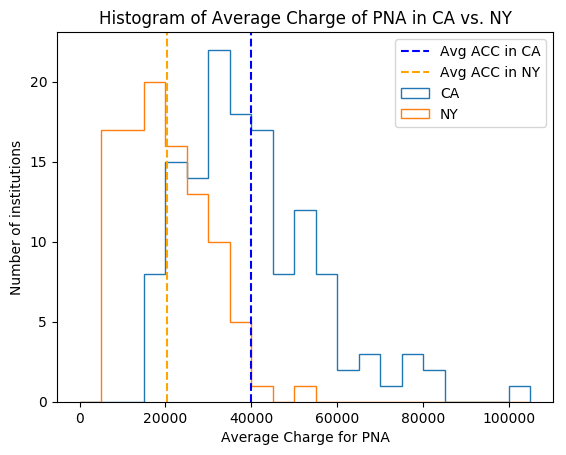

In [25]:
bins = np.arange(0, 110000, 5000)
plt.hist(cal[acc], bins=bins, histtype='step', label="CA")
plt.hist(ny[acc], bins=bins, histtype='step', label="NY")
plt.axvline(cal[acc].mean(), color="blue", label="Avg ACC in CA", linestyle='dashed')
plt.axvline(ny[acc].mean(), color='orange', label="Avg ACC in NY", linestyle='dashed')
plt.xlabel("Average Charge for PNA")
plt.ylabel("Number of institutions")
plt.title("Histogram of Average Charge of PNA in CA vs. NY")
plt.legend()
plt.show()

### We can test whether these distributions are normal by using QQ plots.

In [26]:
normal_ny = np.random.normal(0, 1, len(ny[acc]))
normal_cal = np.random.normal(0, 1, len(cal[acc]))
normal_ny.sort()
normal_cal.sort()

In [27]:
ny_vals = ny[acc].sort_values()
cal_vals = cal[acc].sort_values()

??? Put these side 

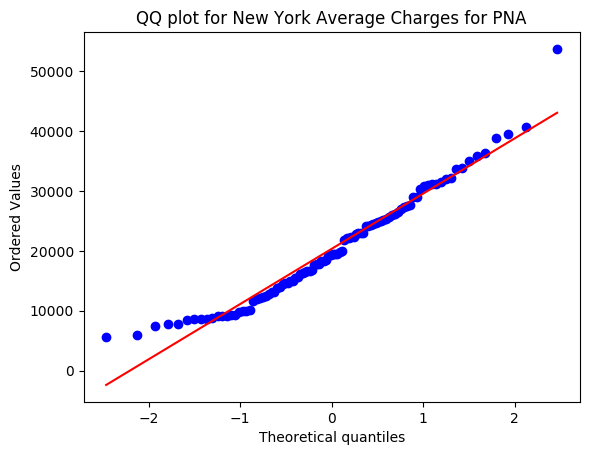

In [28]:
measurements = np.random.normal(loc = 20, scale = 5, size=100)  
# returns tuples
(osm, osr), (slope, intercept, r) = stats.probplot(ny_vals, dist="norm", plot=plt)
plt.title("QQ plot for New York Average Charges for PNA")
plt.show()

In [29]:
# you reject the assumption
stats.jarque_bera(ny_vals)

(7.9404191460179172, 0.018869478187419575)

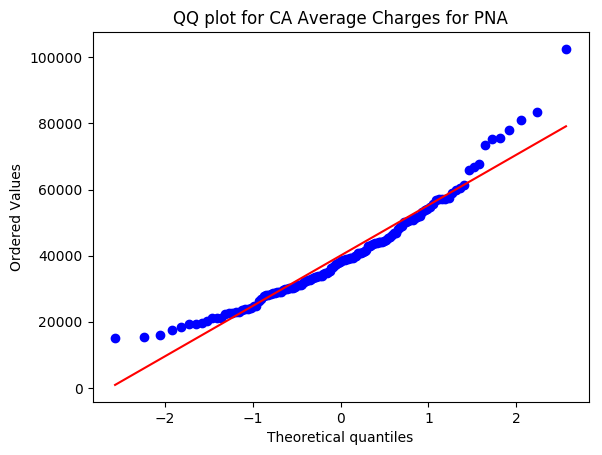

0.968827645325


In [30]:
(osm, osr), (slope, intercept, r) = stats.probplot(cal_vals, dist="norm", plot=plt)
plt.title("QQ plot for CA Average Charges for PNA")
plt.show()

print(r)

In [31]:
stats.jarque_bera(cal_vals)

(37.475627708557987, 7.2823381769282491e-09)

### So NY seems more normally distributed than California, though neither sample is _that_ normal. The sample size for NY is 100 providers and 134 providers in CA. 

### Chosing a statistical test to determine whether the mean values of the distribution are different.

Given that the distributions of our samples are not normal, a Mann-Whitney U test is our test of choice.

In [32]:
# works by comparing the medians, not the means
# distribution is reasonably normal, which supports use of the T-test; finite variance
# mann whitney hugh test compares medians to medians / orders the values
# ttest makes asscumptions about how the data is distributed (parametric test => relies on the data coming from a particular distribution w/ particular parameters)
# non-parametric test => does not need specific parameters in the distributions it tests (e.g. median)
print(stats.mannwhitneyu(ny_vals, cal_vals))
print(stats.ttest_ind(ny_vals, cal_vals, equal_var=False))

MannwhitneyuResult(statistic=1647.0, pvalue=3.0100533344227426e-23)
Ttest_indResult(statistic=-12.041679026237272, pvalue=4.8684688835686721e-26)


The p-value < 5% indicates that there was a less than 5% chance of getting these two distributions if, infact, the cost of a pneumonia hospitalization was the same in these two regions. We can therefore say that the prices in the regions are likely different.

## Q6: Is there a relationship between the number of hospitals in a HRR and average charge they request for a DRG?

We can plot the average covered charge for a given DRG in an HRR and plot it against the number of providers within the HRR to get a sense of the relationship. We can perform a linear regression to assess for the significance of this relationship. Given that there are hundreds of DRG's, we will start by just looking at the relation between ACC and the number of providers in a HRR. 

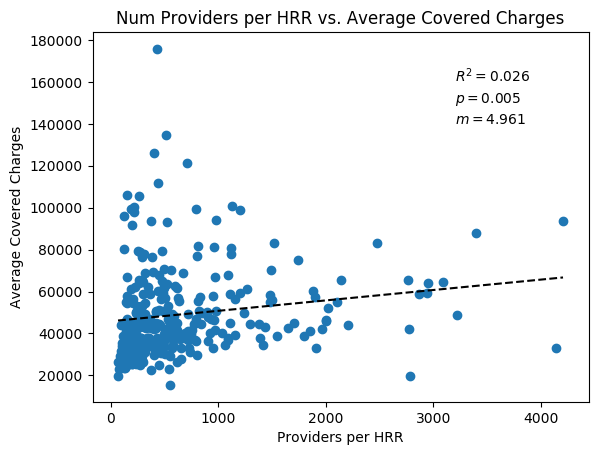

In [95]:
providers_per_hrr = df.groupby([hrr]).agg({acc : np.mean, 'Provider Id' : 'count'})
x = providers_per_hrr['Provider Id']
y = providers_per_hrr['Average Covered Charges']
m, b, r, p, e = stats.linregress(x, y)
line_x = np.array([x.min(), x.max()])
line_y = m * line_x + b
plt.plot(line_x, line_y, '--k')
plt.scatter(x=providers_per_hrr['Provider Id'], y=providers_per_hrr['Average Covered Charges'])
plt.title("Num Providers per HRR vs. Average Covered Charges")
plt.xlabel("Providers per HRR")
plt.ylabel("Average Covered Charges")
plt.text(3200, 160000, '$R^2={:.3f}$'.format(r*r))
plt.text(3200, 150000, '$p = {:.3f}$'.format(p))
plt.text(3200, 140000, '$m = {:.3f}$'.format(m))

plt.show()

There is an increase in the average covered charge made to medicare as the number of providers increases. This is interesting, as more competition (i.e. more providers per HRR) would make me suspect that the prices would go down as insurers and patients have more hospitals to choose from. However, it is also very likely in these areas with a high number of hospitals per HRR that there are a lot of people, which would result in increased demand for hospital services. 

Let's further investigate this by performing linear regressions comparing the number of providers per HRR to the Average Covered Charge per DRG. 

In [148]:
providers_per_hrr_per_DRG = df.groupby(['DRG Definition', hrr]).agg({
    'Provider Id' : 'count', acc : np.mean}).reset_index()

DRG_list = providers_per_hrr_per_DRG['DRG Definition'].unique()

stat_summary = pd.DataFrame(columns=['num_provs_per_DRG_avg', 'HRR_count', 'HRR_min', \
                                     'HRR_max', 'min_cost', 'max_cost', "cost_range", 'avg_cost', 'm','p', 'r'])
for DRG in DRG_list:
    DRG_df = providers_per_hrr_per_DRG[providers_per_hrr_per_DRG['DRG Definition'] == DRG]
    num_provs_per_DRG_avg = DRG_df['Provider Id'].mean()
    cost_DRG_per_HRR_avg = DRG_df[acc].mean()
    HRR_count = DRG_df[hrr].count()
    max_cost = DRG_df[DRG_df[acc] == DRG_df[acc].max()][acc].values[0]
    min_cost = DRG_df[DRG_df[acc] == DRG_df[acc].min()][acc].values[0]
    cost_range = max_cost - min_cost
    HRR_min = DRG_df[DRG_df[acc] == DRG_df[acc].max()][hrr].values[0]
    HRR_max = DRG_df[DRG_df[acc] == DRG_df[acc].min()][hrr].values[0]
    m, b, r, p, e = stats.linregress(DRG_df['Provider Id'], DRG_df[acc])
    stat_summary.loc[DRG , :] = num_provs_per_DRG_avg, \
        HRR_count, HRR_min, HRR_max, min_cost, max_cost, cost_range, cost_DRG_per_HRR_avg, m, p, r

In [35]:
significant_and_pos = stat_summary[(stat_summary.p < .05) & (stat_summary.m > 0)]
significant_and_neg = stat_summary[(stat_summary.p < .05) & (stat_summary.m < 0)]
insignificant = stat_summary[stat_summary.p >= .05]

In [65]:
print(significant_and_pos.shape[0])
print(significant_and_neg.shape[0])
print(insignificant.shape[0])

67
0
430


### Observations
Of the 564 unique DRG's, we were only able to perform linear regressions on 497 of them. Of those 497, 67 had a positive slope and were statistically significant. There were 0 DRG's that had a statistically significant negative relationship between number of providers per HRR and ACC (i.e. cheaper charges when there are more providers in a given area). The remaining 430 regressions were not statistically significant.

This, like the above aggregate graph is intersting to me as it seems to vioalte some economics 101 assumptions - that increasing the supply of a good should result in lowered cost. However, as noted above, we are not accounting for the demand side of that equation, as areas that have more hospitals also, in all likelihood, have more patients to take care of. Below we will investigate this relationship further. 

## Q7: what about the relationship between population enrolled in medicare within an HRR and ACC for a DRG in a given HRR? 

To account for this, we will merge in data from the Medicare Beneficiaries file imported above. 

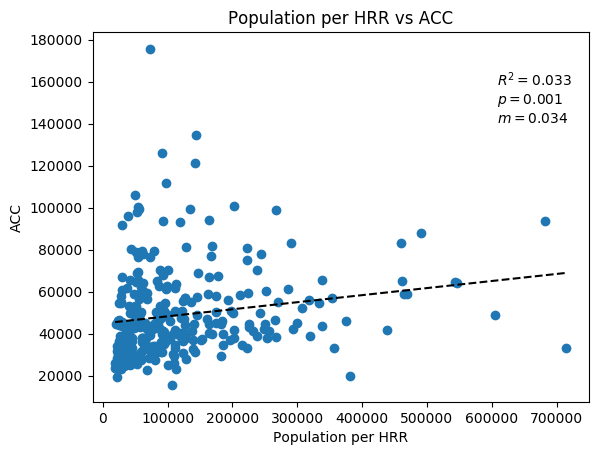

In [94]:
grouped_HRR_df = df.groupby(hrr).agg({"Total Discharges" : np.sum, "Provider Id" : "count", acc : np.mean}).reset_index()

enrollees = 'Medicare Beneficiaries Enrolled in FFS Part A'
bennies = pd.merge(grouped_HRR_df, HRR_names_and_beneficiaries, how='left', left_on=hrr, right_on='HRR Name')
missing_rows = np.where(pd.isnull(bennies))[0]
missing_rows = np.unique(missing_rows)
len(missing_rows) # there are 170 missing rows out of 57665
bennies = bennies.dropna()

y = bennies[acc]
x = bennies[enrollees]
m, b, r, p, e = stats.linregress(x, y)
x_line = np.array([x.min(), x.max()])
y_line = m * x_line + b
plt.scatter(x, y)
plt.plot(x_line, y_line, '--k')
plt.text(x.max() * .85, y.max()* .9, '$R^2={:.3f}$'.format(r*r))
plt.text(x.max() * .85, y.max() * .85, '$p = {:.3f}$'.format(p))
plt.text(x.max() * .85, y.max() * .80, '$m = {:.3f}$'.format(m))
plt.title("Population per HRR vs ACC")
plt.xlabel("Population per HRR")
plt.ylabel("ACC")
plt.show()

This graph shows that there is a statistically significant positive relationsihp between population per HRR and the average covered cost. This jives well with the above analysis that showed an increase in averaged covered cost as the number of providers per HRR increase.

### Let's see how medicare population per HRR relates to ACC for each DRG. 

In [96]:
# this gives the total discharges and num of unique providers
unique_providers = df.groupby(['DRG Definition', hrr]).agg({"Total Discharges" : np.sum,
                                                            "Provider Id" : 'count', 
                                                            acc : np.mean})

# resets the index
unique_providers_reset = unique_providers.reset_index()
filtered = unique_providers_reset

enrollees = 'Medicare Beneficiaries Enrolled in FFS Part A'
bennies = pd.merge(filtered, HRR_names_and_beneficiaries, how='left', left_on=hrr, right_on='HRR Name')
missing_rows = np.where(pd.isnull(bennies))[0]
missing_rows = np.unique(missing_rows)
len(missing_rows) # there are 170 missing rows out of 57665
bennies = bennies.dropna()




In [102]:
bennies

,DRG Definition,Hospital Referral Region (HRR) Description,Total Discharges,Provider Id,Average Covered Charges,HRR Code,HRR Name,Medicare Beneficiaries Enrolled in FFS Part A,Medicare Beneficiaries Enrolled in FFS Part B
0,001 - HEART TRANSPLANT OR IMPLANT OF HEART ASS...,AL - Birmingham,13,1,1.172866e+06,1.0,AL - Birmingham,332912.0,313260.0
1,001 - HEART TRANSPLANT OR IMPLANT OF HEART ASS...,AZ - Phoenix,20,1,4.375313e+05,12.0,AZ - Phoenix,352817.0,322596.0
2,001 - HEART TRANSPLANT OR IMPLANT OF HEART ASS...,CA - Los Angeles,57,2,1.799698e+06,56.0,CA - Los Angeles,682316.0,630783.0
3,001 - HEART TRANSPLANT OR IMPLANT OF HEART ASS...,CA - Sacramento,25,1,8.156741e+05,77.0,CA - Sacramento,266669.0,248227.0
4,001 - HEART TRANSPLANT OR IMPLANT OF HEART ASS...,CA - San Francisco,20,1,1.556265e+06,81.0,CA - San Francisco,142874.0,127905.0
5,001 - HEART TRANSPLANT OR IMPLANT OF HEART ASS...,CA - San Mateo County,23,1,2.238699e+06,85.0,CA - San Mateo County,73567.0,63136.0
6,001 - HEART TRANSPLANT OR IMPLANT OF HEART ASS...,CT - Hartford,17,1,5.241018e+05,110.0,CT - Hartford,201610.0,182089.0
7,001 - HEART TRANSPLANT OR IMPLANT OF HEART ASS...,CT - New Haven,12,1,1.127301e+06,111.0,CT - New Haven,197733.0,175939.0
8,001 - HEART TRANSPLANT OR IMPLANT OF HEART ASS...,DC - Washington,31,1,7.807814e+05,113.0,DC - Washington,356849.0,310001.0
9,001 - HEART TRANSPLANT OR IMPLANT OF HEART ASS...,FL - Gainesville,16,1,5.909152e+05,120.0,FL - Gainesville,86518.0,80181.0


In [149]:
population_HRR_regression_df = pd.DataFrame(columns=["avg_acc", "num_HRRs", "avg_provs_per_HRR", "m", "p", "r"])
for DRG in bennies['DRG Definition'].unique():
    dx = bennies[bennies['DRG Definition']==DRG]
    x = dx[enrollees]
    y = dx[acc]
    avg_acc = dx[acc].mean()
    avg_provs_per_HRR = dx['Provider Id'].mean()
    num_HRRs = dx.shape[0]
    m, b, r, p, e = stats.linregress(x, y)
    population_HRR_regression_df.loc[DRG] = avg_acc, num_HRRs, avg_provs_per_HRR, m, p, r

In [112]:
significant_and_pos = population_HRR_regression_df[(population_HRR_regression_df.p < .05) & (population_HRR_regression_df.m > 0)]
significant_and_neg = population_HRR_regression_df[(population_HRR_regression_df.p < .05) & (population_HRR_regression_df.m < 0)]
insignificant = population_HRR_regression_df[population_HRR_regression_df.p >= .05]

In [113]:
print(insignificant.shape[0])
print(significant_and_neg.shape[0])
print(significant_and_pos.shape[0])

296
0
201


### Observations
Of the 564 unique DRG's, we were again only able to perform linear regressions on 497 of them. Of those 497, 201 had a positive slope and were statistically significant. There were 0 DRG's that had a statistically significant negative relationship between number of providers per HRR and ACC (i.e. cheaper charges when there are more providers in a given area). The remaining 296 regressions were not statistically significant.

Overall, this suggests that an increase in the size of the medicare population in an HRR is associated with an increased charge for a given DRG (or at least 201 of them). This makes sense to me as medicare reimburses significantly less for a given DRG compared to private insurers. The more medicare patients you have, the more you need to charge patients off of medicare to recoup the losses you sustain from medicare's poor reimbursement. 

A limitation to the above is that the medicare population is only a fraction of the whole popualtion. It would be great to see how the cost varied base on the percentage of the population that receives medicare within an HRR (or the popuation as a whole within an HRR), yet I don't have a good dataset on that right now. Something to keep in mind for the future!

## Q8: Do teaching hospitals charge more for a given diagnosis than non-teaching hospitals?

This is common belief in the medical community. Intuitively, one would think this to be the case for several reasons. Teaching hospitals take on the burden of teaching medical students in residents, which takes time and effort that is reflected in the cost. Additionally, if trainees are taking care of patients, perhaps there are more mistakes make, more unnecessary medical imaging and labs ordered, more malpractice insurance to buy. Furthermore, academic institutions are usually research powerhouses that take care of more complex patients (e.g. those that require organ transplants, or those referred from secondary care centers). 

Let's see if, indeed, teaching hospitals do charge more for non-teaching hospitals. To simplify this analysis, we can assess this within the HRR's around Manhattan. Doing so will hopefully control for regional varianace. 

In [41]:
# ??? this filter is not working well....how to make it better?
# e.g. michican and mayo clinic Florida. What's the best way to double check
teaching_names = teaching_hospitals['Hospital Name'].str.lower()

# bunch of attempts to ensure we find matches between the df's
df['teaching_hospital'] = df['Provider Name'].str.upper().isin(
    teaching_names.str.upper()) | df['Provider Street Address'].isin(
    teaching_hospitals['Street Address'].str.upper()) | df['Provider Name'].isin(
    teaching_hospitals['PECOS Legal Business Name'].str.upper())

In [42]:
# reordering columns
df.columns
col_ls = list(df.columns)
th = col_ls.pop()
col_ls.insert(3, th)
df = df[col_ls]

### Comparing non-teaching vs. teaching Hospitals - is there a difference in price?

We can do this with a histogram. Below is a histogram of ACC's for teaching hospitals (ths) vs. non-teaching hospitals (nths). The range is max-range is truncated to emphasize the difference in ACC's. 

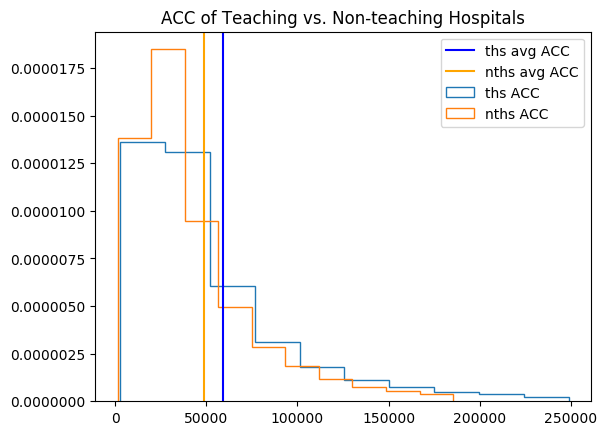

In [140]:
ths = df[df.teaching_hospital == True]
nths = df[df.teaching_hospital == False]
n1, bins1, patches1 = plt.hist(ths[acc], normed=True, range=(ths[acc].min(), ths[acc].max()/9), histtype='step', label='ths ACC')
n2, bins2, patches2 = plt.hist(nths[acc], normed=True, range=(nths[acc].min(), nths[acc].max()/9), histtype='step', label='nths ACC')
ths_avg_acc = ths[acc].mean()
nths_avg_acc = nths[acc].mean()
plt.axvline(ths_avg_acc, color='blue', label = 'ths avg ACC')
plt.axvline(nths_avg_acc, color='orange', label="nths avg ACC")
plt.legend()
plt.title("ACC of Teaching vs. Non-teaching Hospitals")
plt.show()

In [141]:
# statistical test
stats.ttest_ind(ths[acc], nths[acc])

Ttest_indResult(statistic=36.966112978338749, pvalue=3.9896282006200123e-298)

### Interpretation:

Two-sided t-test was significant. T-statistic = difference between the sample standard errors. This implies the the average ACC of teaching hospitals is different from the average ACC of non teaching hospitals. 

In [150]:
th_stats_df = pd.DataFrame(columns=['avg_acc_th', 'avg_acc_nth', 'num_th', 'num_nth', 'std_th', 
                                   'std_nth', 't', 'p'])
for DRG in df['DRG Definition'].unique():
    th_DRG = ths[ths['DRG Definition'] == DRG]
    nth_DRG = nths[nths['DRG Definition'] == DRG]
    
    avg_acc_th = th_DRG[acc].mean()
    avg_acc_nth = nth_DRG[acc].mean()
    num_th = th_DRG.shape[0]
    num_nth = nth_DRG.shape[0]
    std_th = th_DRG[acc].std()
    std_nth = nth_DRG[acc].std()
    
    t, p = stats.ttest_ind(th_DRG[acc], nth_DRG[acc])
    
    th_stats_df.loc[DRG, :] = avg_acc_th, avg_acc_nth, num_th, num_nth, std_th, std_nth, t, p
    
print("Gross results:", th_stats_df.shape)
th_stats_df = th_stats_df.dropna()
print("Removing nan values (e.g. only teaching hospitals do certain DRGs):", th_stats_df.shape[0])
th_sig_and_more = th_stats_df[(th_stats_df.avg_acc_th > th_stats_df.avg_acc_nth) & (th_stats_df.p < .05)]
print("ACC of TH > than NTH (significant):", th_sig_and_more.shape[0])
th_sig_and_less = th_stats_df[(th_stats_df.avg_acc_th < th_stats_df.avg_acc_nth) & (th_stats_df.p < .05)]
print("ACC of TH < than NTH (significant):",th_sig_and_less.shape[0])
th_insignificant = th_stats_df[(th_stats_df.p >= .05)]
print("comparison insignificant:",th_insignificant.shape[0])

Gross results: (459, 8)
Removing nan values (e.g. only teaching hospitals do certain DRGs): 459
ACC of TH > than NTH (significant): 106
ACC of TH < than NTH (significant): 1
comparison insignificant: 352


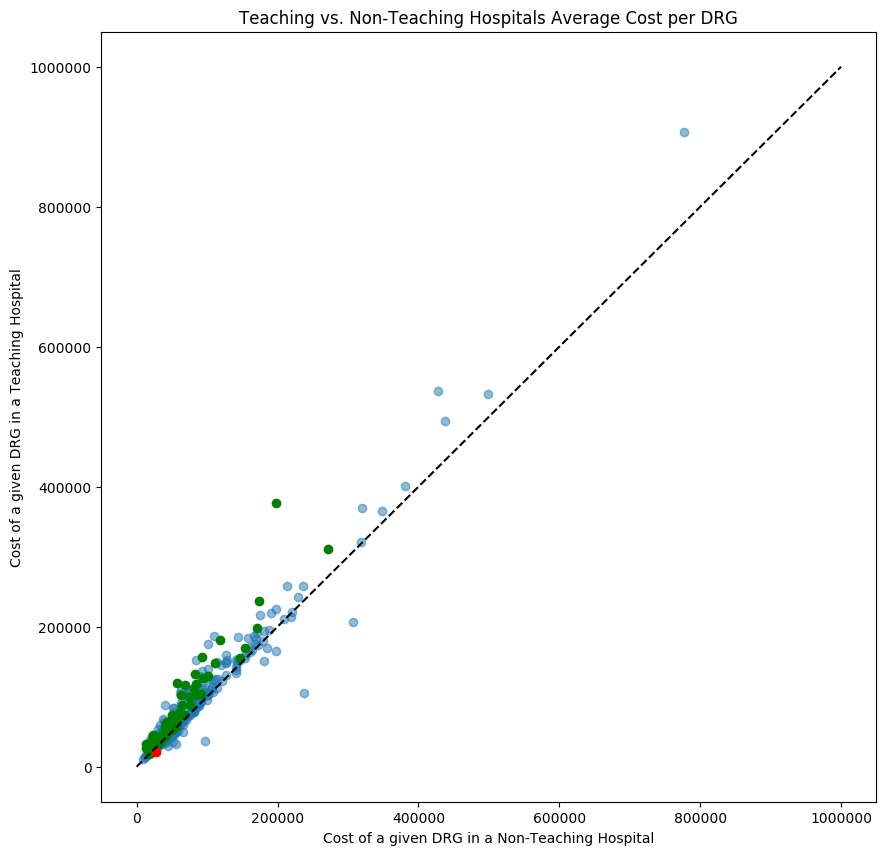

In [151]:
plt.figure(figsize=(10,10))
plt.scatter(th_insignificant.avg_acc_nth, th_insignificant.avg_acc_th, alpha=.5)
plt.scatter(th_sig_and_more.avg_acc_nth, th_sig_and_more.avg_acc_th, c='g')
plt.scatter(th_sig_and_less.avg_acc_nth, th_sig_and_less.avg_acc_th, c='r')
x_line = [-0, 1000000]
y_line = x_line
plt.plot(x_line, y_line, '--k')
plt.title('Teaching vs. Non-Teaching Hospitals Average Cost per DRG')
plt.xlabel('Cost of a given DRG in a Non-Teaching Hospital')
plt.ylabel('Cost of a given DRG in a Teaching Hospital')
plt.show()

### Insurance analysis

A significant proportion of the US population relies on private insurance rather than medicare. Private insurers negotiate with individual hospitals to establish a master charge list. The competitiveness of a given region's insurance market and the number of hospital providers in each region determine each provider and insurer's relative bargaining power in establishing prices. [This](http://kff.org/other/state-indicator/large-group-insurance-market-competition/?currentTimeframe=0 "Title") dataset has some excellent private insurance market geared that will enable us to assess the relationship between the competitiveness of a state's private insurance market and the ACC a provider charges. 

Note: "The *Herfindahl-Hirschman Index (HHI)* is a measure of how evenly market share is distributed across insurers in the market. HHI values range from 0 to 10,000, with an HHI closer to zero indicating a more competitive market and closer to 10,000 indicating a less competitive market. An HHI index below 1,000 generally indicates a highly competitive market; an HHI between 1,000 and 1,500 indicates an unconcentrated market; a score between 1,500 and 2,500 indicates moderate concentration; and a value above 2,500 indicates a highly concentrated (uncompetitive) market."





In [48]:
insurance_df = pd.read_csv("Private_insurers_raw_data.csv")

us_state_abbrev = {
    'Alabama': 'AL',
    'Alaska': 'AK',
    'Arizona': 'AZ',
    'Arkansas': 'AR',
    'California': 'CA',
    'Colorado': 'CO',
    'Connecticut': 'CT',
    'Delaware': 'DE',
    'Florida': 'FL',
    'Georgia': 'GA',
    'Hawaii': 'HI',
    'Idaho': 'ID',
    'Illinois': 'IL',
    'Indiana': 'IN',
    'Iowa': 'IA',
    'Kansas': 'KS',
    'Kentucky': 'KY',
    'Louisiana': 'LA',
    'Maine': 'ME',
    'Maryland': 'MD',
    'Massachusetts': 'MA',
    'Michigan': 'MI',
    'Minnesota': 'MN',
    'Mississippi': 'MS',
    'Missouri': 'MO',
    'Montana': 'MT',
    'Nebraska': 'NE',
    'Nevada': 'NV',
    'New Hampshire': 'NH',
    'New Jersey': 'NJ',
    'New Mexico': 'NM',
    'New York': 'NY',
    'North Carolina': 'NC',
    'North Dakota': 'ND',
    'Ohio': 'OH',
    'Oklahoma': 'OK',
    'Oregon': 'OR',
    'Pennsylvania': 'PA',
    'Rhode Island': 'RI',
    'South Carolina': 'SC',
    'South Dakota': 'SD',
    'Tennessee': 'TN',
    'Texas': 'TX',
    'Utah': 'UT',
    'Vermont': 'VT',
    'Virginia': 'VA',
    'Washington': 'WA',
    'West Virginia': 'WV',
    'Wisconsin': 'WI',
    'Wyoming': 'WY',
    "District of Columbia" : "DC"
}

insurance_df.loc[:, 'location'] = insurance_df.location.map(us_state_abbrev)

insurance_merge = pd.merge(df, insurance_df, how='left', left_on="Provider State", right_on="location")

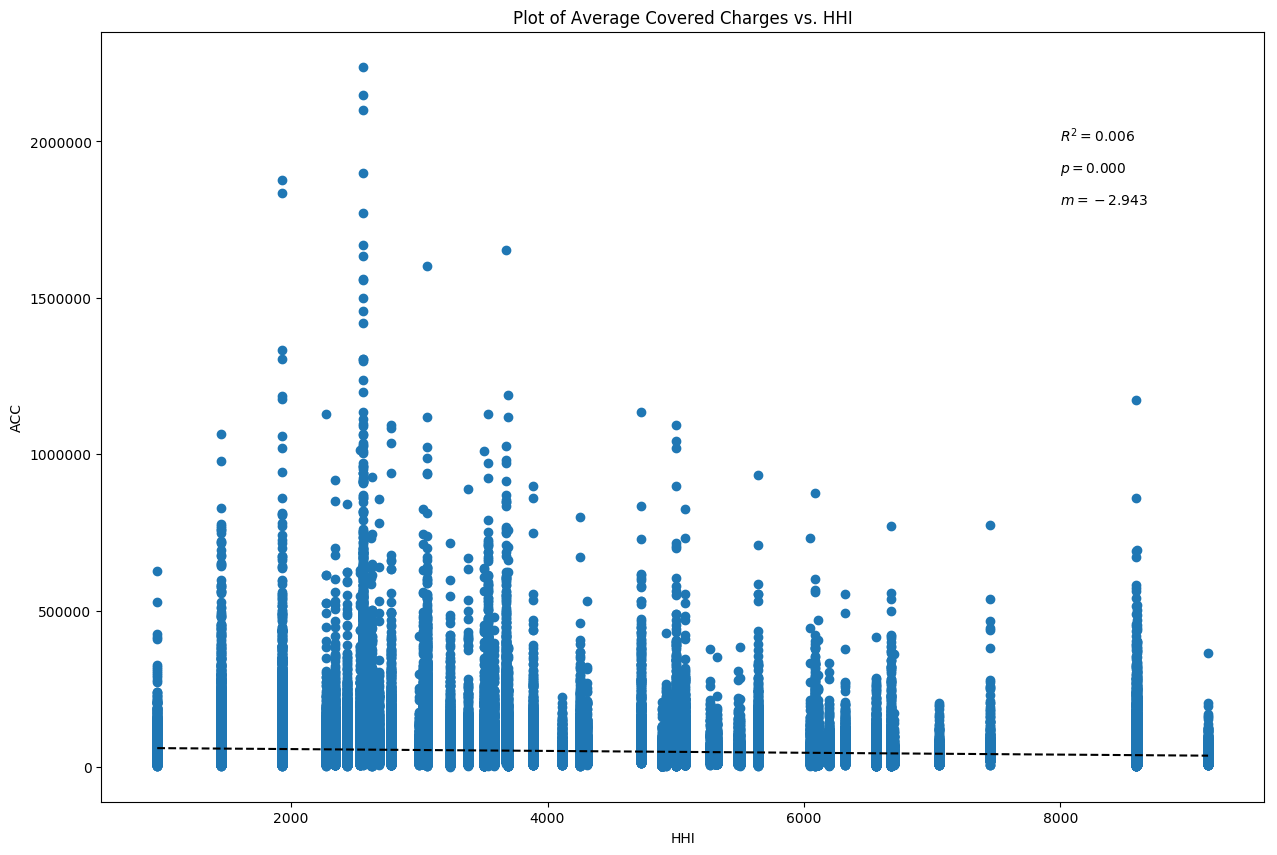

In [49]:
# Not the most useful graph; better way to graph discrete values?

accs = insurance_merge[acc]
HHI = insurance_merge.HHI
m, b, r, p, e = stats.linregress(HHI, accs)
x_line = np.array([HHI.min(), HHI.max()])
y_line = m * x_line + b

plt.figure(figsize=(15, 10))
plt.text(8000, 2000000, "$R^2={:.3f}$".format(r*r))
plt.text(8000, 1900000, "$p={:.3f}$".format(p))
plt.text(8000, 1800000, "$m={:.3f}$".format(m))
plt.plot(x_line, y_line, 'k--')
plt.scatter(HHI, accs)
plt.title("Plot of Average Covered Charges vs. HHI")
plt.xlabel("HHI")
plt.ylabel("ACC")
plt.show()

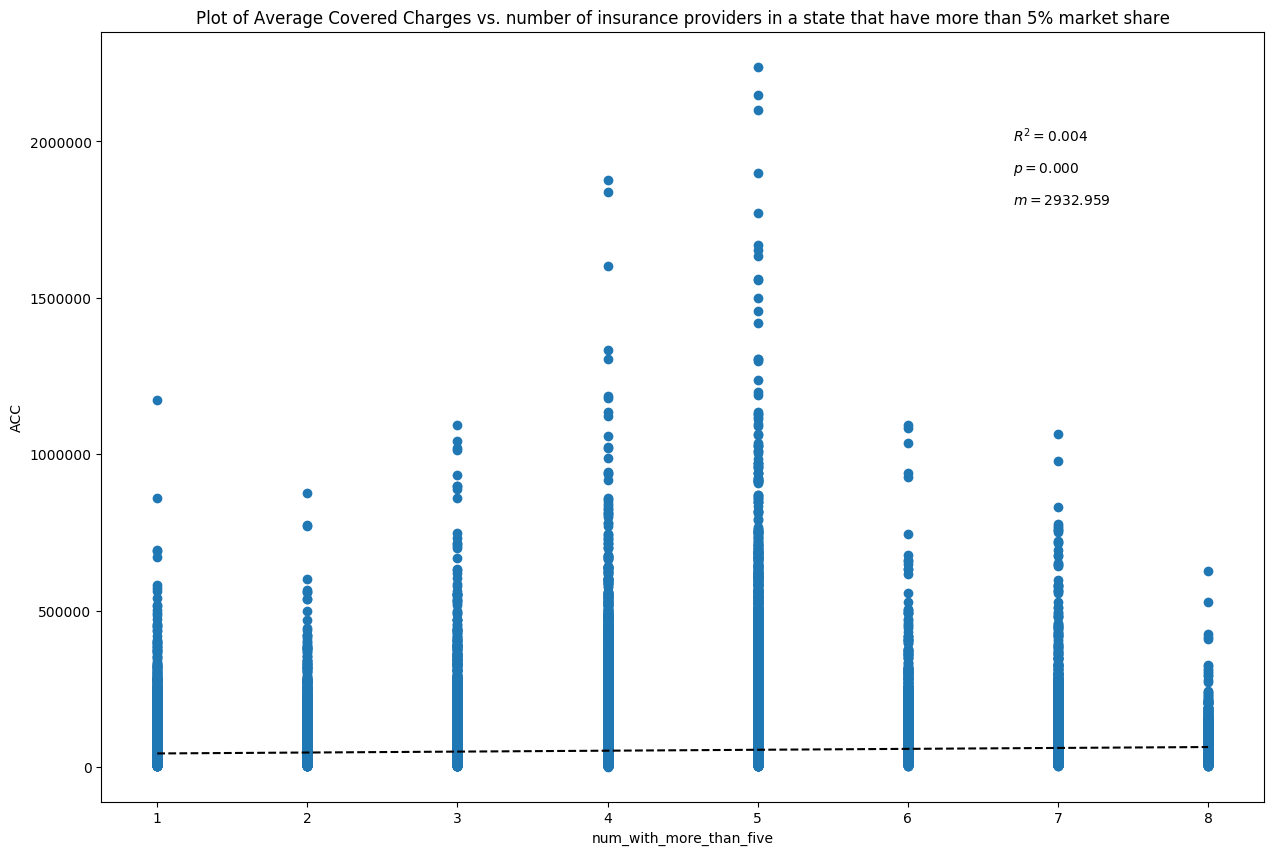

In [145]:
accs = insurance_merge[acc]
num_with_more_than_five = insurance_merge.num_with_more_than_five
m, b, r, p, e = stats.linregress(num_with_more_than_five, accs)
x_line = np.array([num_with_more_than_five.min(), num_with_more_than_five.max()])
y_line = m * x_line + b

plt.figure(figsize=(15, 10))
plt.text(6.7, 2000000, "$R^2={:.3f}$".format(r*r))
plt.text(6.7, 1900000, "$p={:.3f}$".format(p))
plt.text(6.7, 1800000, "$m={:.3f}$".format(m))
plt.plot(x_line, y_line, 'k--')
plt.scatter(num_with_more_than_five, accs)
plt.title("Plot of Average Covered Charges vs. number of insurance providers in a state that have more than 5% market share")
plt.xlabel("num_with_more_than_five")
plt.ylabel("ACC")
plt.show()

In [52]:
std = df.groupby('Provider State')[acc].transform(np.std)
df = df.assign(std_state_cost = std)

In [53]:
state_cost_df = df.groupby(['DRG Definition', 'Provider State']).agg({'Provider Id' : 'count', 
                                                  acc : np.mean, "std_state_cost" : np.mean}).reset_index()
state_cost_df= pd.merge(state_cost_df, insurance_df, how='left', left_on="Provider State", right_on="location")

In [152]:
HHI_by_DRG_regression = pd.DataFrame(columns=['avg_cost', 'num_providers', 'max_cost', 'min_cost', "cost_dif", 'std_costs', "r", "p", "m"])

for DRG in state_cost_df['DRG Definition'].unique():
    DRG_df = state_cost_df[state_cost_df['DRG Definition'] == DRG]
    ACCs = DRG_df[acc]
    HHIs = DRG_df.HHI
    
    m, b, r, p, e = stats.linregress(HHIs, ACCs)
    avg_cost = ACCs.mean()
    max_cost = ACCs.max()
    min_cost = ACCs.min()
    std_costs = ACCs.std()
    num_providers = DRG_df['Provider Id'].sum()
    cost_dif = m * (HHIs.max() - HHIs.min())
    
    HHI_by_DRG_regression.loc[DRG, :] = avg_cost, num_providers, max_cost, min_cost, cost_dif, std_costs, r, p, m

In [56]:
HHI_by_DRG_regression = HHI_by_DRG_regression.assign(m_floor=HHI_by_DRG_regression.m.map(np.floor))

In [57]:
rank = np.arange(HHI_by_DRG_regression.shape[0])
temp_sort = HHI_by_DRG_regression.sort_values('avg_cost')
temp_sort = temp_sort.assign(cost_rank=rank)
temp_sort.sort_index(inplace=True)
HHI_by_DRG_regression = temp_sort

In [59]:
sig_HHI_by_DRG = HHI_by_DRG_regression[HHI_by_DRG_regression.p < .05]
insig_HHI_by_DRG = HHI_by_DRG_regression[HHI_by_DRG_regression.p >= .05]

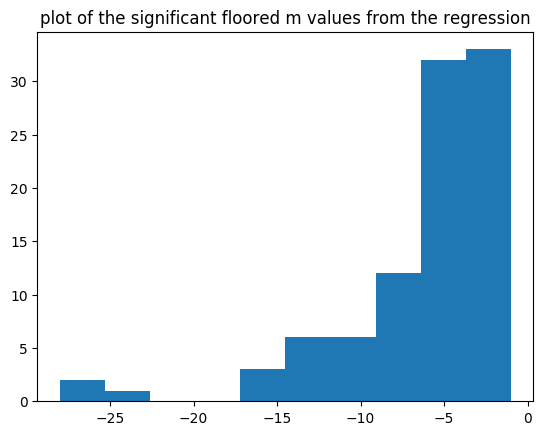

In [60]:
plt.hist(sig_HHI_by_DRG.m_floor)
plt.title("plot of the significant floored m values from the regression")
plt.show()

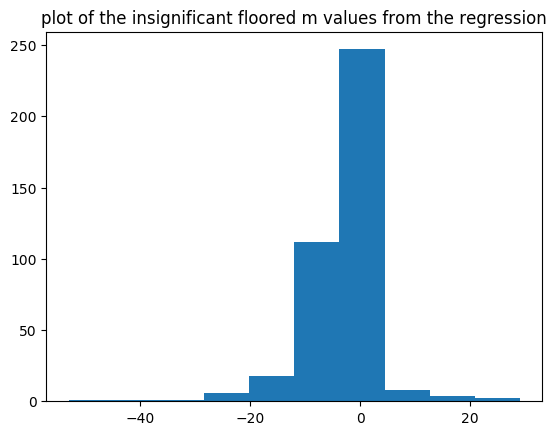

In [61]:
plt.hist(insig_HHI_by_DRG.m_floor)
plt.title("plot of the insignificant floored m values from the regression")
plt.show()

In [147]:
# some of the characteristics of the significant regressions...
sig_HHI_by_DRG.sort_values('p', ascending=True)

,avg_cost,num_providers,max_cost,min_cost,cost_dif,std_costs,r,p,m,m_floor,cost_rank
742 - UTERINE & ADNEXA PROC FOR NON-MALIGNANCY W CC/MCC,50035.5,109,100393,16055,-41216.3,18408,-0.537344,0.000419766,-5.39269,-6.0,306
091 - OTHER DISORDERS OF NERVOUS SYSTEM W MCC,44076.9,319,84580.8,22024,-29524.3,15169,-0.462814,0.00155976,-3.6014,-4.0,243
743 - UTERINE & ADNEXA PROC FOR NON-MALIGNANCY W/O CC/MCC,30932.5,260,56789.8,13695.7,-20701.7,10984.1,-0.444426,0.00222448,-2.68923,-3.0,147
982 - EXTENSIVE O.R. PROCEDURE UNRELATED TO PRINCIPAL DIAGNOSIS W CC,76515.1,433,141376,29454.1,-38924.3,21515.2,-0.421249,0.00319069,-4.74802,-5.0,413
620 - O.R. PROCEDURES FOR OBESITY W CC,51206.5,115,109666,16910.3,-33308.2,17555.7,-0.459776,0.0032323,-4.358,-5.0,313
"406 - PANCREAS, LIVER & SHUNT PROCEDURES W CC",84760.7,133,176301,34623.4,-49244.4,26552,-0.443874,0.00323454,-6.00688,-7.0,434
375 - DIGESTIVE MALIGNANCY W CC,34444.8,395,65245.3,14712.6,-18850.9,10348.7,-0.43135,0.00346272,-2.29945,-3.0,179
240 - AMPUTATION FOR CIRC SYS DISORDERS EXC UPPER LIMB & TOE W CC,67404.7,169,169549,28841.7,-56542.8,29703.3,-0.468237,0.00347038,-7.39799,-8.0,391
"086 - TRAUMATIC STUPOR & COMA, COMA <1 HR W CC",32110,534,72761.3,10748.4,-18367.1,10659.9,-0.401389,0.00425694,-2.24044,-3.0,156
857 - POSTOPERATIVE OR POST-TRAUMATIC INFECTIONS W O.R. PROC W CC,57572.9,172,132560,21816.5,-41328.3,22970.1,-0.44736,0.00429765,-5.04127,-6.0,349


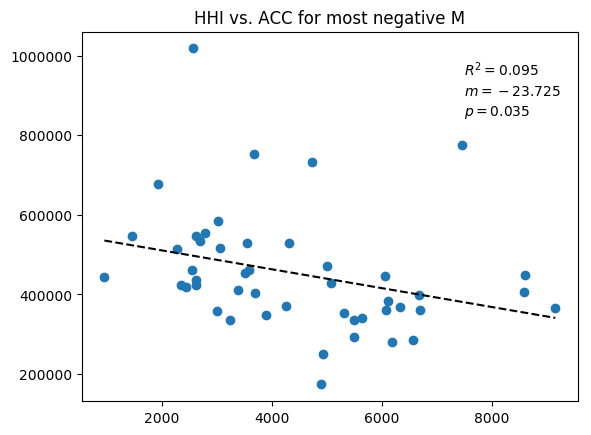

In [64]:
# example grpah of the DRG with the most negative m

sample_DRG = sig_HHI_by_DRG[sig_HHI_by_DRG == sig_HHI_by_DRG.m.min()].index[0]
sample_DRG_df = state_cost_df[state_cost_df['DRG Definition'] == sample_DRG]

x = sample_DRG_df.HHI
y = sample_DRG_df[acc]
m, b, r, p, e = stats.linregress(sample_DRG_df.HHI, sample_DRG_df[acc])

plt.scatter(x, y)
x_line = np.array([x.min(), x.max()])
y_line = m * x_line + b
plt.plot(x_line, y_line, '--k')
plt.text(7500, 900000, "$m={:.3f}$".format(m))
plt.text(7500, 950000, "$R^2={:.3f}$".format(r*r))
plt.text(7500, 850000, "$p={:.3f}$".format(p))
plt.title("HHI vs. ACC for most negative M")
plt.show()

Interesting. All the significant regressions showed a negative m...! Suggesting that less competetive insurance industries lead to higher charged costs from hospitals!

### Next steps: 
* a more formal assessment of whether a provider who charges more or less for one DRG is likely to charge more or less for other DRGs
* assessing relationship between ACC and population within each HRR or percentage of population on medicare
* doing the appropriate statistical tests to see whether teaching hospitals charge more / less than non-teaching hospitals for particular DRG's in particular regions.
* some multivariate regressions combining the above variables (i.e. population on medicare, total population, number of providers per HRR, competitiveness of private insurance market)
